TO DO:

Last changes:
histogram of time cycles
PCA, Screeplot and loadings  -> select 
plot of settings and sensor measurements: using floating window approach to flatten noise -> 
 

In [1]:
# Packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [2]:
# define header
header_txt = ["unit_number","time_cycle", "setting_1", "setting_2", "setting_3",
              "sensor_1", "sensor_2", "sensor_3","sensor_4","sensor_5","sensor_6", "sensor_7", "sensor_8", "sensor_9", 
              "sensor_10", "sensor_11", "sensor_12", "sensor_13", "sensor_14", "sensor_15", "sensor_16", "sensor_17", 
              "sensor_18", "sensor_19", "sensor_20", "sensor_21"] 

## Import data

train_FD001

In [3]:
## import FD001 & remove empty columns

df_train_FD001 = pd.read_csv("../CMAPSSdata/train_FD001.txt", sep=" ", header = None)
df_train_FD001=df_train_FD001.drop([26,27], axis=1)
df_train_FD001.name = "train_FD001"

In [4]:
df_train_FD001.columns = header_txt # add header to datafile

#df_train_FD001 = df_train_FD001.groupby("unit_number",group_keys=False).apply(lambda x: x.assign(RUL = x["time_cycle"].max() - x["time_cycle"])) #https://medium.com/@dreamferus/predictive-maintenance-in-python-exploratory-analysis-and-visualization-de363d5a39de 
print("The data set train_FD001 has", df_train_FD001.shape[0],"rows and",df_train_FD001.shape[1], "columns.")
no_units_train_FD001 = max(df_train_FD001["unit_number"]);
print("The data set train_FD001 has",no_units_train_FD001 ,"test observations / units." )

df_train_FD001.head()

The data set train_FD001 has 20631 rows and 26 columns.
The data set train_FD001 has 100 test observations / units.


,unit_number,time_cycle,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


unit_number
1      192
2      287
3      179
4      189
5      269
      ... 
96     336
97     202
98     156
99     185
100    200
Name: time_cycle, Length: 100, dtype: int64


Text(0, 0.5, 'number of units')

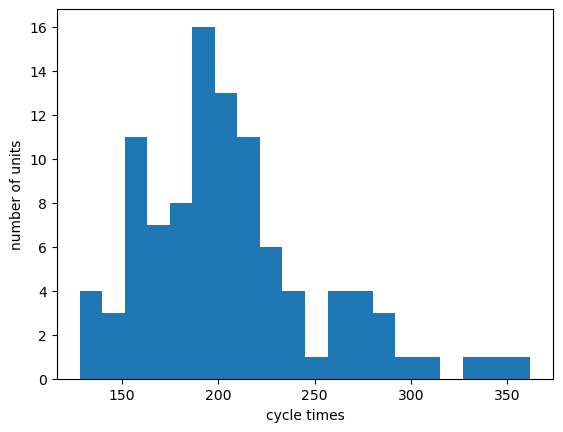

In [5]:
# print cycle time to failure max_time_cycles
curr_dataSet = df_train_FD001
max_time_cycle = curr_dataSet.groupby("unit_number")["time_cycle"].max() #  cycle times per unit
print(max_time_cycle)

# show histogram of max_time_cycles
plt.hist(max_time_cycle, bins=20)
plt.xlabel("cycle times")
plt.ylabel("number of units")


In [6]:
def rolling_rms(x, N): # quelle: https://dsp.stackexchange.com/questions/74814/is-there-a-python-method-to-calculate-moving-rms-of-a-signal-how-to-calculate-t
  return (pd.DataFrame(abs(x)**2).rolling(N).mean()) **0.5

In [7]:
def floatingRMS(curr_dataSet,windowLength):
    return (pd.DataFrame(abs(curr_dataSet)**2).rolling(windowLength).mean()) **0.5

In [17]:
# normalisierter Trainingssatz
df_norm_train_FD001= df_train_FD001.copy()
df_norm_train_FD001=df_norm_train_FD001.drop(columns=["setting_3", "sensor_1", "sensor_5", "sensor_6","sensor_10","sensor_16","sensor_18","sensor_19"])
df_norm_train_FD001.head()


,unit_number,time_cycle,setting_1,setting_2,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044


In [18]:
df_norm_train_FD001.transform(lambda x: (x - x.min()) / (x.max()-x.min()))
df_norm_train_FD001.head()

,unit_number,time_cycle,setting_1,setting_2,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044


In [40]:
# plot measurement singals for sensor number [s1, s2, ...] and unit (array) of data_Set
def plotFeatures(curr_dataSet,sensorID, unitNumber):
    print("Sensor %.f" %sensorID)
    plt.figure
    plt.ylabel("sensor measurement %.f \n rolling RMS" %sensorID)
    plt.xlabel("time")
    for i in unitNumber:  
        #plt.plot(curr_dataSet[curr_dataSet["unit_number"]==i]["time_cycle"], curr_dataSet[curr_dataSet["unit_number"]==i]["sensor_"+str(sensorID)], label= "sensor measurements")
        #plt.plot(curr_dataSet[curr_dataSet["unit_number"]==i]["time_cycle"], curr_dataSet[curr_dataSet["unit_number"]==i]["sensor_"+str(sensorID)].rolling(window=30).mean(), label= "sensor measurements")
        
        plt.plot(floatingRMS(curr_dataSet=curr_dataSet[curr_dataSet["unit_number"]==i]["sensor_"+str(sensorID)].values,windowLength=30),label=("rolling RMS: window 30"))
        # plt.plot(floatingRMS(curr_dataSet=df_train_FD001,sensorID=2, unitNumber=1,windowLength=20),label=("rolling RMS: window 20"))
        #plt.plot(curr_dataSet[curr_dataSet["unit_number"]==unitNumber]["time_cycle"], curr_dataSet[curr_dataSet["unit_number"]==unitNumber]["sensor_"+str(i)].std(axis=0), label="std")
        plt.legend()
    plt.show()
"""
    plt.figure(2)
    plt.ylabel("std of sensor measurement %.f" %sensorID)
    plt.xlabel("time")
    plt.plot(curr_dataSet[curr_dataSet["unit_number"]==unitNumber]["time_cycle"], curr_dataSet[curr_dataSet["unit_number"]==unitNumber]["sensor_"+str(sensorID)].rolling(window=30).std(), label="rolling std")
    plt.legend()
""" 

#plotFeatures(curr_dataSet=df_train_FD001 ,sensorID=2, unitNumber=1)

'\n    plt.figure(2)\n    plt.ylabel("std of sensor measurement %.f" %sensorID)\n    plt.xlabel("time")\n    plt.plot(curr_dataSet[curr_dataSet["unit_number"]==unitNumber]["time_cycle"], curr_dataSet[curr_dataSet["unit_number"]==unitNumber]["sensor_"+str(sensorID)].rolling(window=30).std(), label="rolling std")\n    plt.legend()\n'

Sensor 2


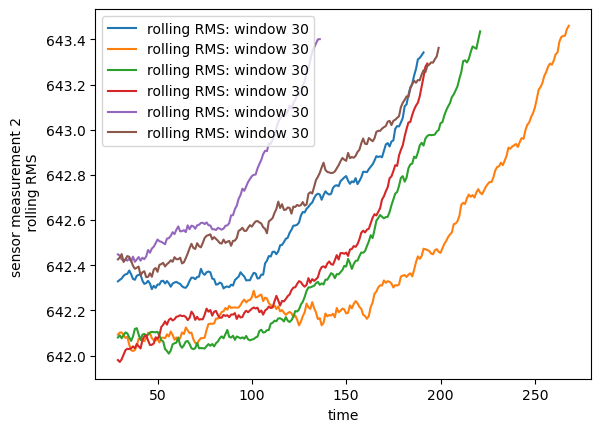

Sensor 7


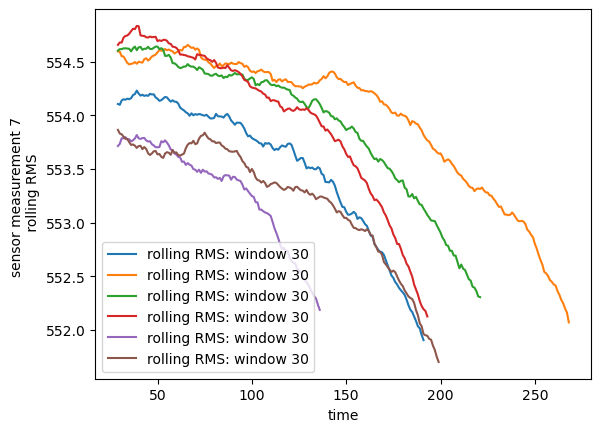

Sensor 14


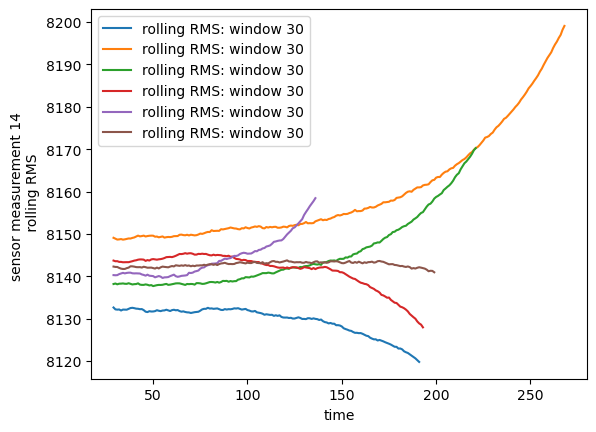

In [41]:
plotFeatures(curr_dataSet=df_norm_train_FD001 ,sensorID=2, unitNumber=[1,5,10,30,70,100])
plotFeatures(curr_dataSet=df_norm_train_FD001 ,sensorID=7, unitNumber=[1,5,10,30,70,100])
plotFeatures(curr_dataSet=df_norm_train_FD001 ,sensorID=14, unitNumber=[1,5,10,30,70,100])


## Functions

Check Outlier

In [ ]:
#curr_dataSet = df_train_FD001

def checkOutlier(curr_dataSet):
    no_rows =curr_dataSet.count(axis=0)
    if len(no_rows[no_rows != len(curr_dataSet)]) > 0: 
        print("ATTENTION: Inconsistent number of rows:\n", no_rows[no_rows != len(curr_dataSet)] )
    else :
        print("All columns have same length.")
    
    if curr_dataSet.isnull().values.any(): #ckeck missing values
        print("ATTENTION: Some values might be missing.")
    else:
        print("No missing values (isnull) detected!")

#checkOutlier(df_train_FD001)


In [ ]:
checkOutlier(df_train_FD001)

Non changing signals

In [ ]:
def checkStdCloseZero(curr_dataSet):# No changing signals - std = 0 
    # for opperating settings -> no influence for RUL
    print("Standard deviation close to zero for " ,curr_dataSet.columns[np.isclose(curr_dataSet.std(axis=0), 0, rtol=1e-05, atol=1e-08, equal_nan=False)].values)
    #print("Sensor singals with std equals null:", curr_dataSet.columns[curr_dataSet.std(axis=0) == 0])

#checkStdCloseZero(df_train_FD001)


In [ ]:
checkStdCloseZero(df_train_FD001)

Visualization of operating settings

In [ ]:
def plotSettings(curr_dataSet, unitNumber):
    for i in range(1,4):
        plt.figure(i)
        plt.xlabel("time_cycle")
        plt.ylabel("operation setting %.f" %i)
        #plt.title('Operation Setting %.f' %i)
        
        for j in unitNumber: # unit
            plt.plot(curr_dataSet[curr_dataSet["unit_number"]==j]["time_cycle"],curr_dataSet[curr_dataSet["unit_number"]==j]["setting_"+str(i)].rolling(window=30).mean(), label = j)
        plt.legend()

#change: rolling average to smoothing        
#df.rolling(window=30).mean()    quelle: https://medium.com/@dreamferus/predictive-maintenance-in-python-exploratory-analysis-and-visualization-de363d5a39de
#visOpSet(df_train_FD001,[1,2,3,4,5])

In [ ]:
plotSettings(df_train_FD001,unitNumber=[1,5,10,20,50,80,99,100])

In [ ]:
df_

Visualization of measurement signals

In [ ]:
# plot measurement singals for sensor number [s1, s2, ...] and unit (array) of data_Set
def plotSensor(curr_dataSet,sensorID, unitNumber):
    for i in sensorID: # number of sensor
        plt.figure(i)
        plt.ylabel("sensor measurement %.f" %i)
        plt.xlabel("time")
        for j in unitNumber: # unit
            plt.plot(curr_dataSet[curr_dataSet["unit_number"]==j]["time_cycle"], curr_dataSet[curr_dataSet["unit_number"]==j]["sensor_"+str(i)], label=j)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=10)
        #plt.ylim(min(curr_dataSet[curr_dataSet["unit_number"]==j]["sensor_"+str(i)]), max(curr_dataSet[curr_dataSet["unit_number"]==j]["sensor_"+str(i)]))

#visMeasure(df_train_FD001)

In [ ]:
plotSensor(df_train_FD001, sensorID=range(1,22), unitNumber=range(1,101)) 


In [ ]:
# Plot correlation matrix of "sensor measurements" 
# input: curr_dataSet = FD00x; unitNumber = 1-xxx

def mapSensorCorr(curr_dataSet,unitNumber):
    # https://thomas-berweger.medium.com/sdfsdf-3678cd946bd0
    plt.figure
    sns.heatmap(curr_dataSet[curr_dataSet["unit_number"]==unitNumber].iloc[:,5:].corr(), cmap='coolwarm', linecolor='white',linewidths=1, annot=True)
    plt.title("Correlation of Signal Measurements "+str(curr_dataSet.name)+ " unit "+str(unitNumber))
    plt.show()



In [ ]:
mapSensorCorr(df_train_FD001,1)


In [ ]:
# https://stackoverflow.com/questions/39409866/correlation-heatmap
def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

def mapSensorCorr2(curr_dataSet,unitNumber):
     cmap = sns.diverging_palette(5, 250, as_cmap=True)
     corr = curr_dataSet[curr_dataSet["unit_number"]==unitNumber].iloc[:,5:].corr()
     return corr.style.background_gradient(cmap, axis=1)\
     .format(precision=3)\
     .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
     .set_caption("Correlation of "+ str(curr_dataSet.name)+ "\n unit"+str(unitNumber))\
     .set_table_styles(magnify())
     


In [ ]:
mapSensorCorr2(df_train_FD001,1)

## PCA
Preform PCA and generate Screeplot

In [42]:
# Compute 
# quelle https://statologie.de/scree-diagramm-python/

unit_number = 1
curr_dataSet = df_train_FD001
scaler = StandardScaler()
# Standardise data (copy)
scaled_df = curr_dataSet[curr_dataSet["unit_number"]==1].iloc[:,[1,2,3,6,7,8,10,11,12,13,14,16,19,20]].copy() # work with copy of data set
scaled_df=pd.DataFrame(scaler.fit_transform(scaled_df), columns=scaled_df.columns)

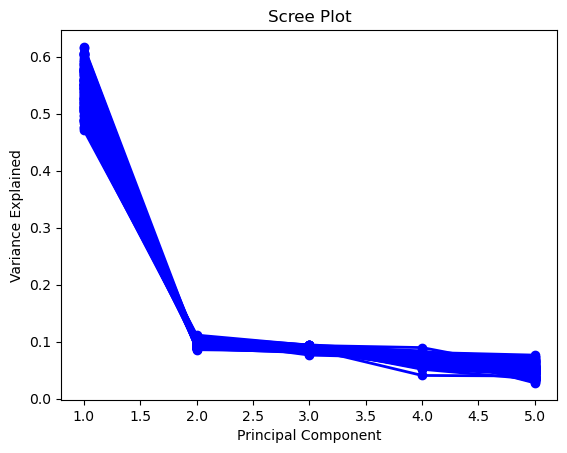

In [43]:

PC_values = []

plt.figure()
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
expl_variance_ratio_over_units = []
loadings = np.zeros((14,5))

i = 1
for i in range(1,101): # unit_number
    scaled_df = curr_dataSet[curr_dataSet["unit_number"]==i].iloc[:,[1,2,3,6,7,8,10,11,12,13,14,16,19,20]].copy()
    scaled_df=pd.DataFrame(scaler.fit_transform(scaled_df), columns=scaled_df.columns)
    pca = PCA(n_components=5)
    pca_fit = pca.fit(scaled_df)
    PC_values = (np.arange(pca.n_components_) + 1)
    plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
    expl_variance_ratio_over_units.append(pca.explained_variance_ratio_)
    curr_loadings = (pca.components_.T * np.sqrt(pca.explained_variance_))>0.5 # check if loading is high, then add +1 to loadings array
    loadings = loadings + curr_loadings.astype(int)


In [50]:

pca.components_



array([[ 3.75679079e-01, -1.46422460e-02,  2.43091964e-02,
         3.04710462e-01,  3.08890845e-01,  3.58826656e-01,
         3.77673334e-02, -3.58224480e-01,  3.58179191e-01,
         1.87355659e-01,  0.00000000e+00, -3.64378913e-01,
         3.39298822e-01,  0.00000000e+00],
       [-3.78900272e-02,  6.99644961e-01,  6.76426308e-01,
        -2.00736323e-02,  6.18691771e-03,  4.50526266e-02,
         1.06918434e-01, -2.30163671e-02,  2.27120438e-02,
        -1.81472591e-01, -1.08420217e-19,  2.46680997e-02,
         5.49526955e-02,  0.00000000e+00],
       [-5.31908442e-02, -1.88346687e-01,  3.42786502e-01,
         8.54363030e-02,  8.51445378e-02,  1.26284049e-02,
        -9.08967720e-01, -6.93900495e-05,  2.06337944e-02,
         1.66857929e-02, -0.00000000e+00,  2.59329859e-02,
        -4.34307964e-02, -0.00000000e+00],
       [ 2.57661905e-02,  6.86247078e-01, -5.79327369e-01,
         5.00695946e-02,  5.47205727e-02, -5.75559195e-02,
        -3.47608464e-01,  2.94453171e-02, -1.

In [ ]:
# generate loadings matrix: matrix show number of units that have a high loading (~ correlation) (loading > 0.5) on the respective principal component PCi
loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2','PC3', 'PC4','PC5'], 
                              index=["sensor_2", "sensor_3","sensor_4", "sensor_7", "sensor_8",
              "sensor_9", "sensor_11", "sensor_12", "sensor_13", "sensor_14", "sensor_15", "sensor_17" ,"sensor_20", "sensor_21"])
print(loading_matrix) 

In [ ]:
#print(expl_variance_ratio_over_units)